# Install Library.

In [6]:
!pip install --quiet openai

# Load Library.

In [5]:
import os
from openai import AzureOpenAI
import base64
from mimetypes import guess_type

# Load Env and Model.

In [105]:
os.environ["OPENAI_API_TYPE"] = "azure_ad"
os.environ["OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = ""
os.environ["AZURE_OPENAI_API_KEY"] = ''


client = AzureOpenAI(
    azure_deployment="gpt-4o",
)

# Use Local Image.

In [106]:
# Function to encode a local image into data URL
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

Data URL: 

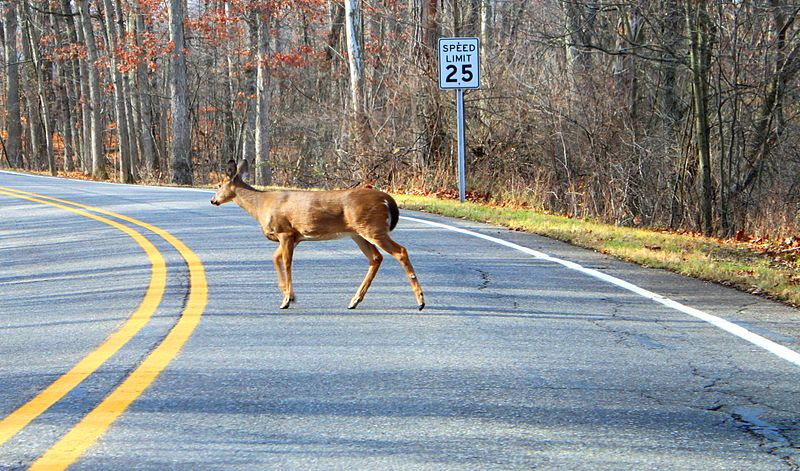

''
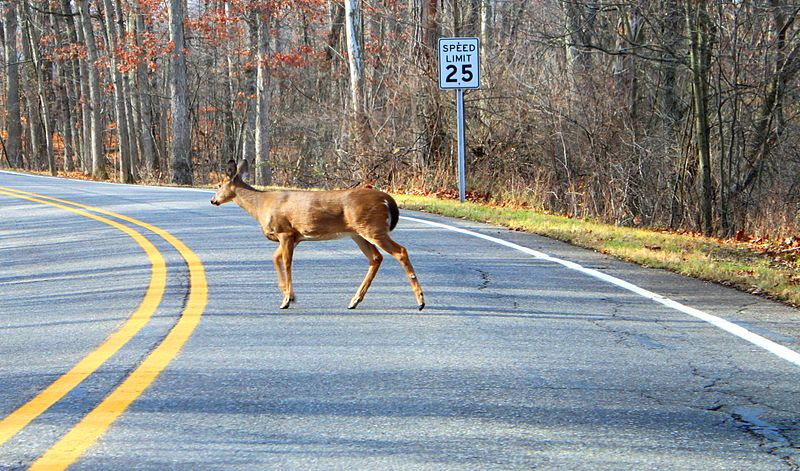

In [107]:
# Example usage
image_path = '/content/test.jpeg'
data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)
data_url

# pass the URL to Model.

In [108]:
system_prompt = """
  You are an expert media analyst. Your expertise includes analyzing and understanding every detail that is present in the media.
  Make sure to include every small details and dynamic objects such as traffic signals, historic sites, road signs, and animals.

  Your Task:
  Carefully examine the following media in detail and provide a detailed, factual, and accurate explanation of what the media depicts.
  If this is a well-known location, please provide me with every relevant detail.
  Highlight all the key elements and their significance, and present your analysis in clear, well-structured markdown format.
"""

In [109]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        { "role": "system",
         "content": system_prompt
        },
        { "role": "user",
          "content": [
            {
                "type": "text",
                "text": "Describe this image: "
            },
            {
                "type": "image_url",
                "image_url":
                 {
                    "url": data_url
                }
            }
        ] }
    ],
    max_tokens=2000
)

In [110]:
print(response.choices[0].message.content)

The image depicts a deer crossing a road in a wooded area. Here are the key elements in the image:

### Key Elements
1. **Deer**: A deer is prominently featured mid-step on the road. The deer appears calm and is looking towards the left (from the viewer's perspective).

2. **Road**:
   - The road has a double yellow line in the middle, indicating a no-passing zone.
   - The road curves to the left ahead of the deer.
   - The surface of the road shows some wear and tear but appears to be in generally good condition.

3. **Speed Limit Sign**:
   - On the right side of the road, there is a speed limit sign indicating a limit of "25" miles per hour.
   - The sign is black and white and is positioned slightly off the road with a grassy strip in between.

4. **Surrounding Environment**:
   - The area is heavily wooded with many trees that have lost their leaves, suggesting the season may be late autumn or early winter.
   - The trees form a dense forest that extends into the background.
   -

# Video Analysis.

In [191]:
!pip install --quiet langchain langchain_openai langchain_community langchain-openai

In [217]:
os.environ["OPENAI_API_TYPE"] = "azure_ad"
os.environ["AZURE_OPENAI_ENDPOINT"]=""
os.environ["AZURE_OPENAI_API_VERSION"]="2024-05-01-preview"
os.environ["AZURE_OPENAI_API_KEY"]=""
os.environ["AZURE_OPENAI_GPT4O_MODEL_NAME"]="gpt-4o"

In [218]:
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_GPT4O_MODEL_NAME"],
    temperature=0,
)

In [223]:
VIDEO_PATH = "/content/testv0.mp4"

In [224]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

In [225]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip

    video.release()

    print(f"Extracted {len(base64Frames)} frames")

    return base64Frames

    # Extract audio from video
    # audio_path = f"{base_video_path}.mp3"
    # clip = VideoFileClip(video_path)
    # clip.audio.write_audiofile(audio_path, bitrate="32k")
    # clip.audio.close()
    # clip.close()

    # print(f"Extracted {len(base64Frames)} frames")
    # print(f"Extracted audio to {audio_path}")
    # return base64Frames, audio_path

In [226]:
# base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)
base64Frames = process_video(VIDEO_PATH, seconds_per_frame=2)


Extracted 11 frames


In [227]:
question = "Describe the video"

In [228]:
system_prompt = """
  You are an expert media analyst. Your expertise includes analyzing and understanding every detail that is present in the media.
  Make sure to include every small details and dynamic objects such as traffic signals, historic sites, road signs, and animals.

  Your Task:
  Carefully examine the following media in detail and provide a detailed, factual, and accurate explanation of what the media depicts.
  If this is a well-known location, please provide me with every relevant detail.
  Highlight all the key elements and their significance, and present your analysis in clear, well-structured markdown format.
"""

In [229]:
messages=[
    {
        "role": "system",
        "content": system_prompt
    },
    {"role": "user", "content": [
        {"type": "text", "text": "These are the frames from the video."},
        *map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames[:9])
        ],
    }
  ]

In [230]:
ai_message = llm.invoke(messages)


print(ai_message.content)


The frames from the video depict a drive through a small town or suburban area during the fall season. Here is a detailed analysis of the key elements in the frames:

### General Overview
- **Season:** The vibrant red, orange, and yellow foliage on the trees indicates that it is autumn.
- **Weather:** The sky is partly cloudy, suggesting a mild, possibly cool day.

### Frame-by-Frame Analysis

#### Frame 1
- **Road:** A two-lane road with a double yellow line in the center.
- **Vehicles:** A blue SUV is parked on the right side of the road, and another vehicle is driving ahead.
- **Buildings:** Various small businesses and shops line the street. A sign on the right reads "Family Health Center."
- **Flags:** An American flag is visible on the left side of the road.
- **Trees:** Trees with autumn foliage are visible in the background.

#### Frame 2
- **Road:** Continuation of the two-lane road.
- **Vehicles:** The same blue SUV is parked on the right, and another vehicle is driving ahead

# OpenAI code.

In [167]:
!pip install opencv-python --quiet
!pip install moviepy --quiet
!pip install --upgrade openai --quiet

In [232]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [233]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64
from openai import OpenAI

client = OpenAI()

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "/content/testv0.mp4"

In [234]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    print(f"Extracted {len(base64Frames)} frames")
    return base64Frames

    # Extract audio from video
    # audio_path = f"{base_video_path}.mp3"
    # clip = VideoFileClip(video_path)
    # clip.audio.write_audiofile(audio_path, bitrate="32k")
    # clip.audio.close()
    # clip.close()

    # print(f"Extracted {len(base64Frames)} frames")
    # print(f"Extracted audio to {audio_path}")

    # return base64Frames, audio_path



In [235]:
# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
# base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)
base64Frames = process_video(VIDEO_PATH, seconds_per_frame=1)

Extracted 22 frames


In [236]:
response = client.chat.completions.create(
    model="gpt-4o",

    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

The video appears to be a drive through a small town or suburban area during autumn. The sequence of frames shows a vehicle moving down a two-lane road lined with buildings, trees, and some parked cars. The trees on both sides of the road are in full fall colors, with vibrant reds, oranges, and yellows. The road is relatively quiet with minimal traffic, and the speed limit signs indicate a limit of 15 mph, suggesting a school zone or a residential area. The weather is clear with a mix of sun and clouds, providing a picturesque view of the autumn scenery.
